# Difference-in-Differences between specific region and others

In [186]:
import numpy as np
import pandas as pd
from typing import Optional
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import statsmodels.formula.api as smf

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [187]:
outcome_var = "log_measurement"
intervention_year: Optional[int] = 2015
intervention_year: Optional[int] = None

treatment_var = "Regions"
# treatment_var_value = "Gulf of Mexico"
treatment_var_value = "Mediterranean Sea"
treatment_var_value = "North Sea"
treatment_var_value = "Caribbean Sea"
treatment_var_value = "Gulf of California"

control_var_dummy_value = "Other Seas"


filepath = "/mnt/d/temp/user/ed/mart/mmplastic/Marine_Microplastics_WGS84_1130715472761438990.csv"

In [188]:
df = pd.read_csv(filepath)
df = df.dropna(subset=["Measurement"])
df['yyyymmdd'] = pd.to_datetime(df['Date'])
df['year'] = df['yyyymmdd'].dt.year
df['month'] = df['yyyymmdd'].dt.month
df['day'] = df['yyyymmdd'].dt.day

df = df.rename(columns={"Sampling Method": "sampling_method", "Density Class": "density"})

df["measurement"] = np.where(df["Measurement"] > 1.0, 1.0, df["Measurement"])
df["log_measurement"] = np.log(df["measurement"])

/tmp/ipykernel_262699/4292777884.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['yyyymmdd'] = pd.to_datetime(df['Date'])
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Min and Max Year of Treatment Var.

In [189]:
year_range = df[df[treatment_var] == treatment_var_value].agg({"year": ["min", "max"]})
if intervention_year is None:
    intervention_year = int((year_range.loc["min"] + (year_range.loc["max"] - year_range.loc["min"])/2).loc["year"])
(
    year_range,
    intervention_year
)

(     year
 min  2001
 max  2018,
 2009)

## Find lower/higher quantile thresholds

In [190]:
def find_quantile_below_threshold(df, column, threshold, quantile_range=(0, 1, 0.005)):
  """
  Finds the highest quantile value less than a given threshold in a Pandas DataFrame column.

  Args:
    df: The Pandas DataFrame.
    column: The name of the column to check.
    threshold: The threshold value.
    quantile_range: A tuple defining the start, end, and step of the quantile range.

  Returns:
    The quantile value that is less than the threshold.
  """

  quantiles = np.arange(*quantile_range)
  for q in quantiles[::-1]:
    quantile_value = df[column].quantile(q)
    if quantile_value < threshold:
      return q, quantile_value
  return None, None  # If no quantile is found

threshold = 0.0
quantile, value = find_quantile_below_threshold(df, 'log_measurement', threshold)
print("Quantile:", quantile)
print("Value:", value)

higher_quantile = quantile

Quantile: 0.86
Value: -0.024470811007744744


In [191]:
def find_quantile_over_threshold(df, column, threshold, quantile_range=(0, 1, 0.005)):
  """
  Finds the lowest quantile value less than a given threshold in a Pandas DataFrame column.

  Args:
    df: The Pandas DataFrame.
    column: The name of the column to check.
    threshold: The threshold value.
    quantile_range: A tuple defining the start, end, and step of the quantile range.

  Returns:
    The quantile value that is less than the threshold.
  """

  quantiles = np.arange(*quantile_range)
  for q in quantiles:
    quantile_value = df[column].quantile(q)
    if quantile_value > threshold:
      return q, quantile_value
  return None, None  # If no quantile is found

threshold = -10.0
quantile, value = find_quantile_over_threshold(df, outcome_var, threshold)
print("Quantile:", quantile)
print("Value:", value)

lower_quantile = quantile

Quantile: 0.32
Value: -6.907755278982137


/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: inva

In [192]:
higher_threshold = np.ceil(df[outcome_var].quantile(higher_quantile) * 100.) / 100.
lower_threshold = np.ceil(df[outcome_var].quantile(lower_quantile) * 1000.) / 1000.

In [193]:
df2 = df.loc[
    (df[outcome_var] > lower_threshold) & (df[outcome_var] < higher_threshold),
    # (df[outcome_var] > lower_threshold) & (df[outcome_var] < higher_threshold) & (df["Oceans"].isin(["Pacific Ocean", "Atlantic Ocean"])),
    :
]

<Axes: xlabel='log_measurement', ylabel='Count'>

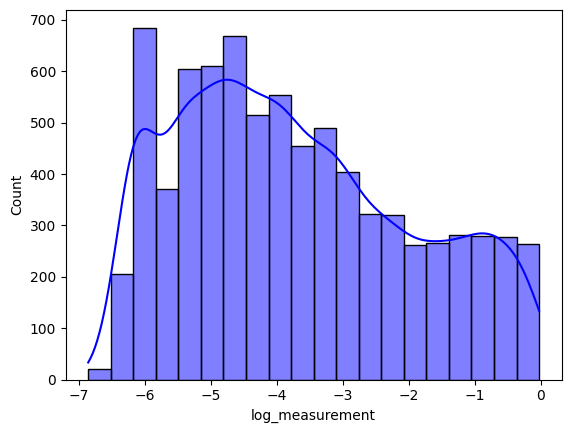

In [194]:
sns.histplot(
    data=df2,
    x="log_measurement",
    bins=20,
    kde=True,
    color="blue",
    alpha=0.5,
)

In [195]:
preproc_df = df2
df = df2

In [196]:
df

,OBJECTID,Oceans,Regions,SubRegions,sampling_method,Measurement,Unit,Density Range,density,Short Reference,Long Reference,DOI,Organization,Keywords,Accession Number,Accession Link,Latitude,Longitude,Date,GlobalID,x,y,yyyymmdd,year,month,day,measurement,log_measurement
0,9676,Atlantic Ocean,NaN,NaN,Grab sample,0.018000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,-31.696000,-48.560000,8/11/2015 12:00:00 AM,a77121b2-e113-444e-82d9-7af11d62fdd2,-48.560000,-31.696000,2015-08-11,2015,8,11,0.018000,-4.017384
2,10672,Pacific Ocean,NaN,NaN,Manta net,0.013000,pieces/m3,0.005-1,Medium,Goldstein et al.2013,"Goldstein, M.C., A.J. Titmus, M. Ford. 2013. S...",https://doi.org/10.1371/journal.pone.0080020,Scripps Institution of Oceanography-University...,Great Pacific Garbage Patch/SEAPLEX,253448,https://www.ncei.noaa.gov/access/metadata/land...,0.500000,-95.350000,10/17/2006 12:00:00 AM,23effcdd-35b7-4e1e-adb4-390693a287d3,-95.350000,0.500000,2006-10-17,2006,10,17,0.013000,-4.342806
6,11597,Pacific Ocean,NaN,NaN,Neuston net,0.631646,pieces/m3,0.005-1,Medium,Eriksen et al.2014,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",https://doi.org/10.1371/journal.pone.0111913,5 Gyres Institute,SV Mir; ORV Alguita; SV Sea Dragon; RV Stad Am...,275968,https://www.ncei.noaa.gov/access/metadata/land...,19.340300,-156.087000,11/24/2007 12:00:00 AM,f9f3119e-d9ae-487c-93d6-27f02e4bb44d,-156.087000,19.340300,2007-11-24,2007,11,24,0.631646,-0.459426
7,8348,Pacific Ocean,NaN,NaN,Neuston net,0.008640,pieces/m3,0.005-1,Medium,Law et al.2014,"Law, K.L, S.K. Morét-Ferguson, D.S. Goodwin, E...",https://doi.org/10.1021/es4053076,Sea Education Association,SEA,211008,https://www.ncei.noaa.gov/access/metadata/land...,33.470000,-151.630000,12/10/2011 12:00:00 AM,be818f7e-f16b-4811-9763-054a6a400e08,-151.630000,33.470000,2011-12-10,2011,12,10,0.008640,-4.751353
9,14253,Atlantic Ocean,North Sea,NaN,Neuston net,0.004425,pieces/m3,0.0005-0.005,Low,"Russell and Webster, 2021","Russell, M., L. Webster. 2021. Microplastics i...",https://doi.org/10.1016/j.marpolbul.2021.112210,Marine Scotland Science,MRV Scotia/MRV Alba na Mara /RV Sir John Murray,259692,https://www.ncei.noaa.gov/access/metadata/land...,58.034333,-3.627833,1/18/2019 12:00:00 AM,8f5b8816-6e22-46b0-ba41-6aac40dcc072,-3.627833,58.034333,2019-01-18,2019,1,18,0.004425,-5.420485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20415,9212,Atlantic Ocean,NaN,NaN,Grab sample,0.006000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.801700,-38.190000,12/5/2014 12:00:00 AM,6bc79c43-0572-4da8-8f45-4275e0a2e95c,-38.190000,17.801700,2014-12-05,2014,12,5,0.006000,-5.115996
20416,8917,Atlantic Ocean,NaN,NaN,Grab sample,0.004000,pieces/m3,0.0005-0.005,Low,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,22.341300,-19.952500,11/12/2014 12:00:00 AM,fa761396-9019-4c6a-a7e5-a4822a8f2926,-19.952500,22.341300,2014-11-12,2014,11,12,0.004000,-5.521461
20419,9366,Atlantic Ocean,NaN,NaN,Grab sample,0.011000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.100000,-47.550000,2/1/2015 12:00:00 AM,fd4db6d6-aed7-48b1-a22b-402557112e2f,-47.550000,17.100000,2015-02-01,2015,2,1,0.01100

In [197]:
len(df[df["Oceans"] == "Pacific Ocean"]), len(df[df["Oceans"] == "Atlantic Ocean"])

(1731, 6005)

In [198]:
df[df["Oceans"] == "Pacific Ocean"]["year"]

2        2006
6        2007
7        2011
13       2005
58       2010
         ... 
20343    2008
20367    2004
20372    2010
20387    2015
20389    2011
Name: year, Length: 1731, dtype: int32

<Axes: xlabel='year', ylabel='Count'>

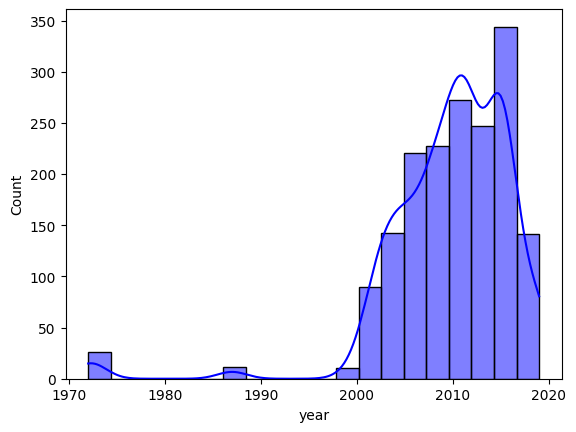

In [199]:
sns.histplot(
    data=df[df["Oceans"] == "Pacific Ocean"],
    x="year",
    bins=20,
    kde=True,
    color="blue",
    alpha=0.5,
)

<Axes: xlabel='year', ylabel='Count'>

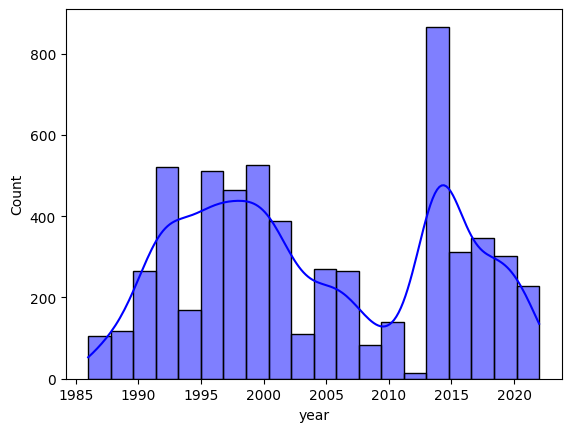

In [200]:
sns.histplot(
    data=df[df["Oceans"] == "Atlantic Ocean"],
    x="year",
    bins=20,
    kde=True,
    color="blue",
    alpha=0.5,
)

## Set post variable
- potential intervention year

In [201]:
df["post"] = (df["year"] > intervention_year).apply(lambda a: int(a))

## Set treated
- intervention region

In [202]:
treatment_condition = (df[treatment_var] == treatment_var_value)
control_condition = (df[treatment_var] != treatment_var_value)

In [203]:
df["treated"] = (treatment_condition).apply(lambda a: int(a))
# df["treated"] = (df["Oceans"] == "Pacific Ocean").apply(lambda a: int(a))

In [204]:
df1 = df[control_condition & (df["post"] == False)]
df1 = df1.assign(dataset=f'{control_var_dummy_value}-Prev')

df2 = df[control_condition & (df["post"] == True)]
df2 = df2.assign(dataset=f'{control_var_dummy_value}-Post')

df3 = df[treatment_condition & (df["post"] == False)]
df3 = df3.assign(dataset=f'{treatment_var_value}-Prev')

df4 = df[treatment_condition & (df["post"] == True)]
df4 = df4.assign(dataset=f'{treatment_var_value}-Post')


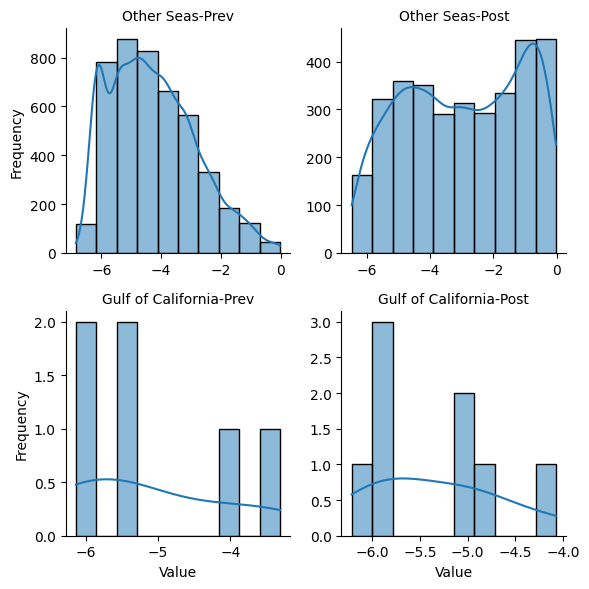

In [205]:
blocks_df = pd.DataFrame({
    f"{control_var_dummy_value}-Prev": df1[outcome_var],
    f"{control_var_dummy_value}-Post": df2[outcome_var],
    f"{treatment_var_value}-Prev": df3[outcome_var],
    f"{treatment_var_value}-Post": df4[outcome_var],
})

# Reshape the DataFrame
df_melt = pd.melt(blocks_df, var_name='Dataset', value_name='Value')

# Creating a FacetGrid
g = sns.FacetGrid(df_melt, col='Dataset', col_wrap=2, sharex=False, sharey=False)

# Mapping the sns.histplot function to each subplot
g.map(sns.histplot, 'Value', kde=True, bins=10, alpha=0.5)

# Adding titles and labels
g.set_titles('{col_name}')
g.set_axis_labels('Value', 'Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [206]:
df.assign(
    w = lambda d: d["treated"] * d["post"]
).groupby(
    ["w"]
).agg(
    {"year": [min, max]}
)

/tmp/ipykernel_262699/3262162751.py:5: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  ).agg(
/tmp/ipykernel_262699/3262162751.py:5: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  ).agg(


year      
    min   max
w            
0  1972  2022
1  2013  2016

## Canonical Difference-in-Differences

In [207]:
did_data = df.groupby(
    ["treated", "post"]
).agg(
    {"log_measurement": "mean", "year": "min"}
)
did_data

log_measurement  year
treated post                       
0       0           -4.273509  1972
        1           -2.941147  2010
1       0           -5.087452  2001
        1           -5.327842  2013

In [208]:
len(df)

7849

In [209]:
len(df[((df["year"] >= 2011) & (df["year"] <= 2019))])

2763

In [210]:
df

,OBJECTID,Oceans,Regions,SubRegions,sampling_method,Measurement,Unit,Density Range,density,Short Reference,Long Reference,DOI,Organization,Keywords,Accession Number,Accession Link,Latitude,Longitude,Date,GlobalID,x,y,yyyymmdd,year,month,day,measurement,log_measurement,post,treated
0,9676,Atlantic Ocean,NaN,NaN,Grab sample,0.018000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,-31.696000,-48.560000,8/11/2015 12:00:00 AM,a77121b2-e113-444e-82d9-7af11d62fdd2,-48.560000,-31.696000,2015-08-11,2015,8,11,0.018000,-4.017384,1,0
2,10672,Pacific Ocean,NaN,NaN,Manta net,0.013000,pieces/m3,0.005-1,Medium,Goldstein et al.2013,"Goldstein, M.C., A.J. Titmus, M. Ford. 2013. S...",https://doi.org/10.1371/journal.pone.0080020,Scripps Institution of Oceanography-University...,Great Pacific Garbage Patch/SEAPLEX,253448,https://www.ncei.noaa.gov/access/metadata/land...,0.500000,-95.350000,10/17/2006 12:00:00 AM,23effcdd-35b7-4e1e-adb4-390693a287d3,-95.350000,0.500000,2006-10-17,2006,10,17,0.013000,-4.342806,0,0
6,11597,Pacific Ocean,NaN,NaN,Neuston net,0.631646,pieces/m3,0.005-1,Medium,Eriksen et al.2014,"Eriksen, M., L.C.M. Lebreton, H.S. Carson, M. ...",https://doi.org/10.1371/journal.pone.0111913,5 Gyres Institute,SV Mir; ORV Alguita; SV Sea Dragon; RV Stad Am...,275968,https://www.ncei.noaa.gov/access/metadata/land...,19.340300,-156.087000,11/24/2007 12:00:00 AM,f9f3119e-d9ae-487c-93d6-27f02e4bb44d,-156.087000,19.340300,2007-11-24,2007,11,24,0.631646,-0.459426,0,0
7,8348,Pacific Ocean,NaN,NaN,Neuston net,0.008640,pieces/m3,0.005-1,Medium,Law et al.2014,"Law, K.L, S.K. Morét-Ferguson, D.S. Goodwin, E...",https://doi.org/10.1021/es4053076,Sea Education Association,SEA,211008,https://www.ncei.noaa.gov/access/metadata/land...,33.470000,-151.630000,12/10/2011 12:00:00 AM,be818f7e-f16b-4811-9763-054a6a400e08,-151.630000,33.470000,2011-12-10,2011,12,10,0.008640,-4.751353,1,0
9,14253,Atlantic Ocean,North Sea,NaN,Neuston net,0.004425,pieces/m3,0.0005-0.005,Low,"Russell and Webster, 2021","Russell, M., L. Webster. 2021. Microplastics i...",https://doi.org/10.1016/j.marpolbul.2021.112210,Marine Scotland Science,MRV Scotia/MRV Alba na Mara /RV Sir John Murray,259692,https://www.ncei.noaa.gov/access/metadata/land...,58.034333,-3.627833,1/18/2019 12:00:00 AM,8f5b8816-6e22-46b0-ba41-6aac40dcc072,-3.627833,58.034333,2019-01-18,2019,1,18,0.004425,-5.420485,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20415,9212,Atlantic Ocean,NaN,NaN,Grab sample,0.006000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.801700,-38.190000,12/5/2014 12:00:00 AM,6bc79c43-0572-4da8-8f45-4275e0a2e95c,-38.190000,17.801700,2014-12-05,2014,12,5,0.006000,-5.115996,1,0
20416,8917,Atlantic Ocean,NaN,NaN,Grab sample,0.004000,pieces/m3,0.0005-0.005,Low,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,22.341300,-19.952500,11/12/2014 12:00:00 AM,fa761396-9019-4c6a-a7e5-a4822a8f2926,-19.952500,22.341300,2014-11-12,2014,11,12,0.004000,-5.521461,1,0
20419,9366,Atlantic Ocean,NaN,NaN,Grab sample,0.011000,pieces/m3,0.005-1,Medium,Barrows et al.2018,"Barrows, A.P.W., S.E. Cathey, C.W. Petersen. 2...",https://doi.org/10.1016/j.envpol.2018.02.062,Adventure Scientist,Adventure Scientist/Citizen Science,211009,https://www.ncei.noaa.gov/access/metadata/land...,17.100000,-47.550000,2/1/2015 12:00:00 AM,fd4db6d6-aed7-48b1-a22b-402557112e2f

## Grid Region by Longitude and Latitude

In [211]:
min_longitude = int(preproc_df["Longitude"].min() - 1)
max_longitude = int(preproc_df["Longitude"].max() + 1)
min_longitude, max_longitude

(-167, 40)

In [212]:
min_latitude = int(preproc_df["Latitude"].min() - 1)
max_latitude = int(preproc_df["Latitude"].max() + 1)
min_latitude, max_latitude

(-46, 89)

In [213]:
(preproc_df["Longitude"].max() - preproc_df["Longitude"].min()) * (preproc_df["Latitude"].max() - preproc_df["Latitude"].min())

27544.7265585571

In [214]:
bin = 20

In [215]:
step_longitude = int((max_longitude - min_longitude) / bin)
step_longitude

10

In [216]:
step_latitude = int((max_latitude - min_latitude) / bin)
step_latitude

6

In [217]:
longitude_bins = range(min_longitude, max_longitude + step_longitude, step_longitude)
latitude_bins = range(min_latitude, max_latitude + step_latitude, step_latitude)

In [218]:
df['lon_bin'] = pd.cut(df['x'], bins=longitude_bins, labels=False, include_lowest=True)
df['lat_bin'] = pd.cut(df['y'], bins=latitude_bins, labels=False, include_lowest=True)


In [219]:
# df["bin_region"] = df.apply(lambda row: f"{int(row['lon_bin'])}-{int(row['lat_bin'])}", axis=1)
df["bin_region"] = df.apply(lambda row: f"{int(row['lon_bin'])}", axis=1)

## Fix dataset

In [220]:
df = df.loc[:, [outcome_var, "year", "treated", "post", "density", treatment_var, "sampling_method"]]

In [221]:
df

,log_measurement,year,treated,post,density,Regions,sampling_method
0,-4.017384,2015,0,1,Medium,NaN,Grab sample
2,-4.342806,2006,0,0,Medium,NaN,Manta net
6,-0.459426,2007,0,0,Medium,NaN,Neuston net
7,-4.751353,2011,0,1,Medium,NaN,Neuston net
9,-5.420485,2019,0,1,Low,North Sea,Neuston net
...,...,...,...,...,...,...,...
20415,-5.115996,2014,0,1,Medium,NaN,Grab sample
20416,-5.521461,2014,0,1,Low,NaN,Grab sample
20419,-4.509860,2015,0,1,Medium,NaN,Grab sample
20420,-3.835062,2001,0,0,Medium,Caribbean Sea,Neuston net


In [222]:
assert len(df[df[treatment_var] == treatment_var_value].loc[df["year"] > intervention_year, :]) > 0

## DiD data

In [223]:
did_data

log_measurement  year
treated post                       
0       0           -4.273509  1972
        1           -2.941147  2010
1       0           -5.087452  2001
        1           -5.327842  2013

In [224]:
y0_est = did_data.loc[1].loc[0, outcome_var] + did_data.loc[0].diff().loc[1, outcome_var]
y0_est

-3.7550899991965525

In [225]:
did_data.loc[1].loc[0, outcome_var], did_data.loc[0].diff().loc[1, outcome_var]

(-5.087452089167413, 1.3323620899708604)

### ATT by diff between treated and y0 estimation

In [226]:
att = did_data.loc[1].loc[1, outcome_var] - y0_est
att

-1.5727517109626228

In [227]:
did_data.loc[0].loc[0, outcome_var] - (did_data.loc[0].loc[0, outcome_var] + did_data.loc[1].diff().loc[1, outcome_var])

0.24038962099176242

## Diff-in-Diff with Outcome Growth
- "Changes in results based on the differentiation of data in the time dimension"

In [228]:
pre = df.query("post == 0").groupby(treatment_var)[outcome_var].mean()
post = df.query("post == 1").groupby(treatment_var)[outcome_var].mean()

In [229]:
pre.index, post.index

(Index(['Caribbean Sea', 'Coastal Waters of Florida',
        'Florida Keys National Marine Sanctuary', 'Gulf of California',
        'Gulf of Mexico', 'Gulf of St. Lawrence', 'New York Bight',
        'Olympic Coast National Marine Sanctuary',
        'Papahanaumokuakea Marine National Monument',
        'Stellwagen Bank National Marine Sanctuary'],
       dtype='object', name='Regions'),
 Index(['Baffin Bay', 'Baltic Sea', 'Barents Sea', 'Bay of Biscay',
        'Beaufort Sea', 'Bering Sea', 'Black Sea', 'Caribbean Sea',
        'Celtic Sea', 'Channel Islands National Marine Sanctuary',
        'Chukchi Sea', 'Coastal Waters of Florida',
        'Coastal Waters of Southeast Alaska and British Columbia',
        'Davis Strait', 'English Channel', 'Greenland Sea', 'Gulf of Alaska',
        'Gulf of California', 'Gulf of Mexico', 'Gulf of St. Lawrence',
        'Hawaiian Islands Humpback Whale National Marine Sanctuary',
        'Hudson Strait', 'Inner Seas off the West Coast of Scotlan

In [230]:
common_index = pre.index.intersection(post.index)
common_index

Index(['Caribbean Sea', 'Coastal Waters of Florida', 'Gulf of California',
       'Gulf of Mexico', 'Gulf of St. Lawrence', 'New York Bight'],
      dtype='object', name='Regions')

In [231]:

pre = pre[common_index]
post = post[common_index]

delta_y = ((post - pre).rename("delta_y").to_frame().join(df.groupby(treatment_var)["treated"].max()))
delta_y.tail()

,delta_y,treated
Regions,,
Coastal Waters of Florida,-1.201776,0
Gulf of California,-0.240390,1
Gulf of Mexico,-0.413940,0
Gulf of St. Lawrence,0.926664,0
New York Bight,0.853107,0


In [232]:
delta_y

,delta_y,treated
Regions,,
Caribbean Sea,1.186769,0
Coastal Waters of Florida,-1.201776,0
Gulf of California,-0.240390,1
Gulf of Mexico,-0.413940,0
Gulf of St. Lawrence,0.926664,0
New York Bight,0.853107,0


In [233]:
len(delta_y), len(pre), len(post), len(df)

(6, 6, 6, 7849)

In [234]:
len(delta_y.index.unique())

6

In [235]:
len(delta_y[delta_y["treated"]==0]), len(delta_y[delta_y["treated"]==1])

(5, 1)

In [236]:
(delta_y.query("treated==1")["delta_y"].mean() - delta_y.query("treated==0")["delta_y"].mean())

-0.5105545595865607

In [237]:
(delta_y.query("treated==0")["delta_y"].mean() - delta_y.query("treated==1")["delta_y"].mean())

0.5105545595865607

In [238]:
delta_y.query("treated==1")["delta_y"].mean(), delta_y.query("treated==0")["delta_y"].mean()

(-0.24038962099176242, 0.2701649385947983)

### DiD plot

In [239]:
did_plt = did_data.reset_index()

did_minmax = did_plt.agg({outcome_var: ["min", "max"]})
did_min, did_max = did_minmax.loc["min"].item(), did_minmax.loc["max"].item()

year_minmax = did_plt.agg({"year": ["min", "max"]})
year_min, year_max = year_minmax.loc["min"].item(), year_minmax.loc["max"].item()

(
    (did_min, did_max),
    (year_min, year_max)
)

((-5.327841710159175, -2.9411468839788895), (1972, 2013))

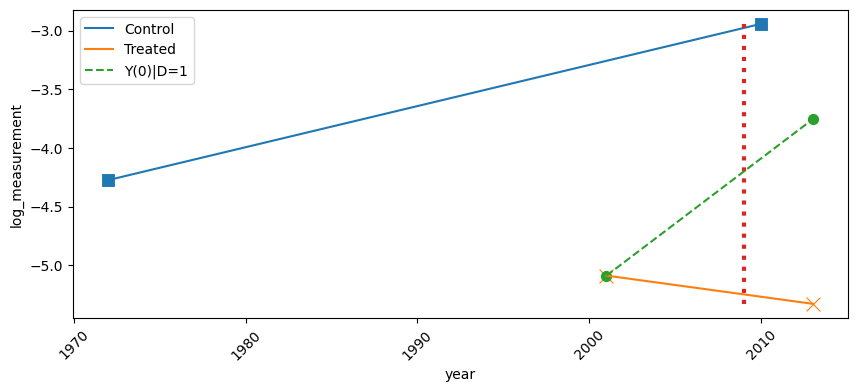

In [240]:
plt.figure(figsize=(10, 4))

sns.scatterplot(data=did_plt.query("treated==0"), x="year", y=outcome_var, s=100, color="C0", marker="s")
sns.lineplot(data=did_plt.query("treated==0"), x="year", y=outcome_var, label="Control", color="C0")

sns.scatterplot(data=did_plt.query("treated==1"), x="year", y=outcome_var, s=100, color="C1", marker="x")
sns.lineplot(data=did_plt.query("treated==1"), x="year", y=outcome_var, label="Treated", color="C1")

plt.vlines(x=intervention_year, ymin=did_min, ymax=did_max, color="C3", ls="dotted", lw=3)

plt.scatter(did_data.loc[1, "year"], [did_data.loc[1, outcome_var][0], y0_est], color="C2", s=50)
plt.plot(did_data.loc[1, "year"], [did_data.loc[1, outcome_var][0], y0_est], color="C2", linestyle="dashed", label="Y(0)|D=1")

plt.xticks(rotation=45)
plt.legend()

## DiD and OLS

In [241]:
did_data = (
    df.groupby(
        [treatment_var, "post"]
    ).agg(
        {outcome_var: "mean", "year": "min", "treated": "max"}
    ).reset_index()
)
did_data

,Regions,post,log_measurement,year,treated
0,Baffin Bay,1,-4.185102,2016,0
1,Baltic Sea,1,-3.398126,2018,0
2,Barents Sea,1,-4.509860,2016,0
3,Bay of Biscay,1,-3.468849,2014,0
4,Beaufort Sea,1,-1.505118,2016,0
5,Bering Sea,1,-5.809143,2016,0
6,Black Sea,1,-1.254097,2017,0
7,Caribbean Sea,0,-5.045143,1987,0
8,Caribbean Sea,1,-3.858373,2013,0
9,Celtic Sea,1,-3.853527,2015,0


### DiD Estimation

In [242]:
import statsmodels.formula.api as smf

model = smf.ols(
    f"{outcome_var} ~ treated*post", data=did_data
).fit()
model.params["treated:post"], model.summary()

(-1.2261051541589194,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:        log_measurement   R-squared:                       0.127
 Model:                            OLS   Adj. R-squared:                  0.066
 Method:                 Least Squares   F-statistic:                     2.077
 Date:                Fri, 02 Aug 2024   Prob (F-statistic):              0.117
 Time:                        11:53:21   Log-Likelihood:                -73.135
 No. Observations:                  47   AIC:                             154.3
 Df Residuals:                      43   BIC:                             161.7
 Df Model:                           3                                         
 Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------

## DiD and unit-fixed effect model

In [243]:
model = smf.ols(
    f"{outcome_var} ~ treated*post + C({treatment_var}) + C(post)", data=did_data
).fit()
model.params["treated:post"], model.summary()

(-0.5105545595865615,
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:        log_measurement   R-squared:                       0.970
 Model:                            OLS   Adj. R-squared:                  0.655
 Method:                 Least Squares   F-statistic:                     3.081
 Date:                Fri, 02 Aug 2024   Prob (F-statistic):              0.140
 Time:                        11:53:21   Log-Likelihood:                 6.0991
 No. Observations:                  47   AIC:                             73.80
 Df Residuals:                       4   BIC:                             153.4
 Df Model:                          42                                         
 Covariance Type:            nonrobust                                         
                                                                               coef    std err          t      P>|t|      [0.025

## DiD and Block Design

In [244]:
df.assign(
    treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
).astype(
    {"year":"str"}
).assign(
    treated=df["treated"]*df["post"]
)

,log_measurement,year,treated,post,density,Regions,sampling_method
0,-4.017384,2015,0,1,Medium,NaN,Grab sample
2,-4.342806,2006,0,0,Medium,NaN,Manta net
6,-0.459426,2007,0,0,Medium,NaN,Neuston net
7,-4.751353,2011,0,1,Medium,NaN,Neuston net
9,-5.420485,2019,0,1,Low,North Sea,Neuston net
...,...,...,...,...,...,...,...
20415,-5.115996,2014,0,1,Medium,NaN,Grab sample
20416,-5.521461,2014,0,1,Low,NaN,Grab sample
20419,-4.509860,2015,0,1,Medium,NaN,Grab sample
20420,-3.835062,2001,0,0,Medium,Caribbean Sea,Neuston net


In [245]:
df

,log_measurement,year,treated,post,density,Regions,sampling_method
0,-4.017384,2015,0,1,Medium,NaN,Grab sample
2,-4.342806,2006,0,0,Medium,NaN,Manta net
6,-0.459426,2007,0,0,Medium,NaN,Neuston net
7,-4.751353,2011,0,1,Medium,NaN,Neuston net
9,-5.420485,2019,0,1,Low,North Sea,Neuston net
...,...,...,...,...,...,...,...
20415,-5.115996,2014,0,1,Medium,NaN,Grab sample
20416,-5.521461,2014,0,1,Low,NaN,Grab sample
20419,-4.509860,2015,0,1,Medium,NaN,Grab sample
20420,-3.835062,2001,0,0,Medium,Caribbean Sea,Neuston net


In [246]:
df3 = df.assign(
    treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
).astype(
    {"year":"str"}
).assign(
    treated=df["treated"]*df["post"]
)

In [247]:
treatment_var

'Regions'

In [248]:
df3 = df3.dropna(subset=[treatment_var])


In [249]:
df3

,log_measurement,year,treated,post,density,Regions,sampling_method
9,-5.420485,2019,0,1,Low,North Sea,Neuston net
19,-0.343640,2018,0,1,Medium,Mediterranean Sea,Manta net
72,-5.444500,1999,0,0,Low,Caribbean Sea,Neuston net
73,-6.137647,2003,0,0,Low,Caribbean Sea,Neuston net
76,-3.142007,1993,0,0,Medium,Caribbean Sea,Neuston net
...,...,...,...,...,...,...,...
20370,-5.809143,2014,0,1,Low,Caribbean Sea,Grab sample
20380,-0.875468,2015,0,1,Medium,Mediterranean Sea,Manta net
20388,-1.072945,2021,0,1,Medium,Mediterranean Sea,Manta net
20420,-3.835062,2001,0,0,Medium,Caribbean Sea,Neuston net


In [250]:
df3[df3["year"].isin(["2021", "2022"])]

,log_measurement,year,treated,post,density,Regions,sampling_method
181,-3.068755,2021,0,1,Medium,Mediterranean Sea,Manta net
245,-0.092115,2021,0,1,Medium,Mediterranean Sea,Manta net
306,-2.336318,2022,0,1,Medium,Inner Seas off the West Coast of Scotland,Neuston net
321,-0.830113,2021,0,1,Medium,Mediterranean Sea,Manta net
393,-0.206558,2021,0,1,Medium,Mediterranean Sea,Manta net
...,...,...,...,...,...,...,...
20020,-1.456734,2021,0,1,Medium,Mediterranean Sea,Manta net
20117,-2.701273,2021,0,1,Medium,North Sea,Neuston net
20286,-2.363333,2022,0,1,Medium,North Sea,Neuston net
20388,-1.072945,2021,0,1,Medium,Mediterranean Sea,Manta net


In [251]:
df4 = df3.groupby([treatment_var, "year"]).agg({outcome_var: "mean"}) #.reset_index()
df4

log_measurement
Regions                                   year                 
Baffin Bay                                2016        -5.518964
                                          2021        -3.918329
Baltic Sea                                2018        -3.984331
                                          2019        -2.441691
                                          2020        -4.405978
...                                                         ...
Stellwagen Bank National Marine Sanctuary 2003        -4.067257
                                          2004        -3.744791
                                          2005        -5.221356
                                          2006        -5.134160
                                          2007        -6.137647

[175 rows x 1 columns]

In [252]:
df5 = df3.set_index([treatment_var, "year"]).join(
    df4, on=[treatment_var, "year"], rsuffix="_mean", how="left"
).drop(columns=outcome_var).rename(columns={f"{outcome_var}_mean": outcome_var}).drop_duplicates().loc[:, ["treated", "post", outcome_var]].drop_duplicates().reset_index()
# check duplicates
# df5[df5.duplicated(subset=[treatment_var, "year"], keep=False)]
df5

,Regions,year,treated,post,log_measurement
0,North Sea,2019,0,1,-4.118103
1,Mediterranean Sea,2018,0,1,-2.106566
2,Caribbean Sea,1999,0,0,-4.811461
3,Caribbean Sea,2003,0,0,-4.908958
4,Caribbean Sea,1993,0,0,-5.277655
...,...,...,...,...,...
156,Celtic Sea,2017,0,1,-3.995242
157,Bay of Biscay,2015,0,1,-2.255902
158,Gulf of California,2016,1,1,-5.809143
159,Caribbean Sea,2018,0,1,-5.222468


In [253]:
df5.pivot(
    index=treatment_var, columns="year", values="treated"
    # index=["year", columns=treatment_var, values="treated"
).reset_index().fillna(0.0) #.loc[df5["Regions"] == "Gulf of California", :]

year,Regions,1987,1989,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Baffin Bay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Baltic Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Barents Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bay of Biscay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Beaufort Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Bering Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Black Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,Caribbean Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Celtic Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,Chukchi Sea,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [254]:
df5[df5["Regions"] == treatment_var_value]

,Regions,year,treated,post,log_measurement
9,Gulf of California,2013,1,1,-4.518194
77,Gulf of California,2014,1,1,-6.011876
113,Gulf of California,2002,0,0,-4.961453
121,Gulf of California,2015,1,1,-5.251151
125,Gulf of California,2001,0,0,-5.213451
158,Gulf of California,2016,1,1,-5.809143


In [255]:
df5.assign(
    treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
).astype(
    {"year":"str"}
).assign(
    treated=df["treated"]*df["post"]
).pivot(
    index=treatment_var, columns="year", values="treated"
).reset_index().fillna(0.0).sort_values(
    max(df["year"].astype(str)), ascending=False
).reset_index(
).drop(
    columns=[treatment_var]
).rename(
    columns={"index": treatment_var}
).set_index(
    treatment_var
)

year,1987,1989,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Regions,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


> TODO bug fix for treatment line and vline

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5]),
 [Text(0.5, 0, '1987'),
  Text(1.5, 0, '1989'),
  Text(2.5, 0, '1991'),
  Text(3.5, 0, '1992'),
  Text(4.5, 0, '1993'),
  Text(5.5, 0, '1994'),
  Text(6.5, 0, '1995'),
  Text(7.5, 0, '1996'),
  Text(8.5, 0, '1997'),
  Text(9.5, 0, '1998'),
  Text(10.5, 0, '1999'),
  Text(11.5, 0, '2000'),
  Text(12.5, 0, '2001'),
  Text(13.5, 0, '2002'),
  Text(14.5, 0, '2003'),
  Text(15.5, 0, '2004'),
  Text(16.5, 0, '2005'),
  Text(17.5, 0, '2006'),
  Text(18.5, 0, '2007'),
  Text(19.5, 0, '2008'),
  Text(20.5, 0, '2010'),
  Text(21.5, 0, '2011'),
  Text(22.5, 0, '2012'),
  Text(23.5, 0, '2013'),
  Text(24.5, 0, '2014'),
  Text(25.5, 0, '2015'),
  Text(26.5, 0, '2016'),
  Text(27.5, 0, '2017'),
  Text(28.5, 0, '2018'),
  Text(29.5, 0, '2019'),
  Text(30.5, 0, '2020'),
  Text(31.5

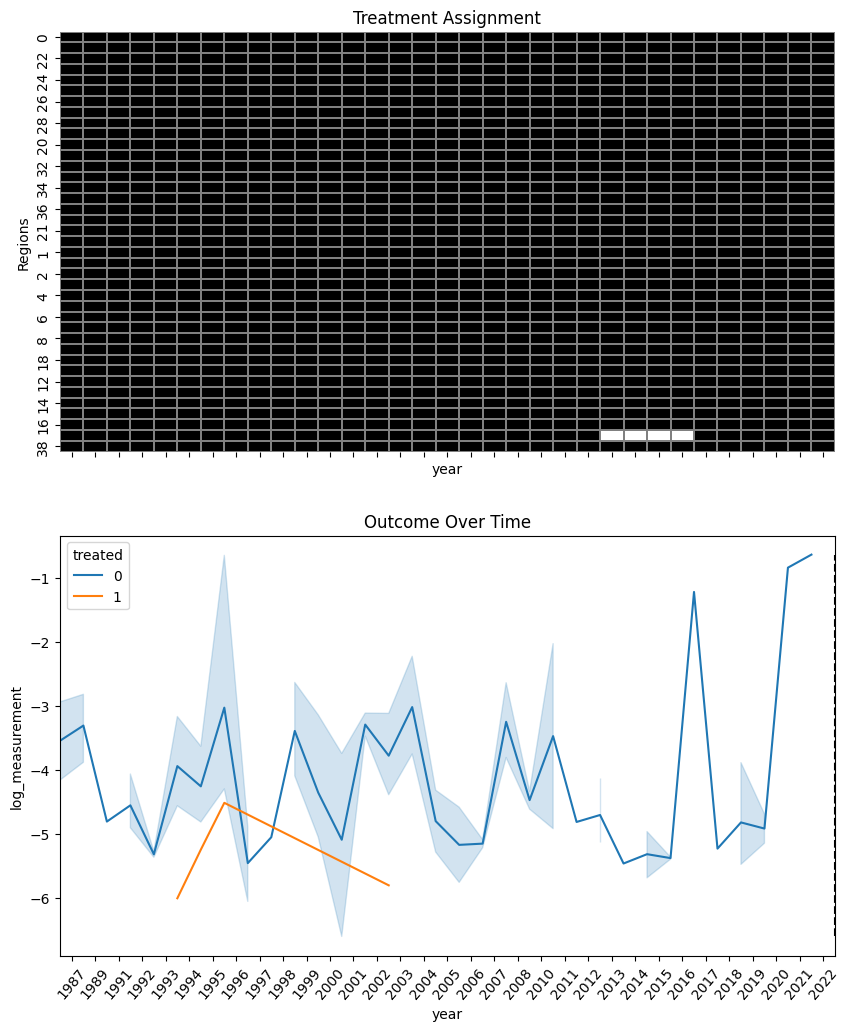

In [256]:
plt_df = df5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

heat_plt = (
    plt_df.assign(
        treated=lambda d: d.groupby(treatment_var)["treated"].transform("max")
    ).astype(
        {"year":"str"}
    ).assign(
        treated=plt_df["treated"]*plt_df["post"]
    ).pivot(
        index=treatment_var, columns="year", values="treated"
    ).reset_index().fillna(0.0).sort_values(
        max(plt_df["year"].astype(str)), ascending=False
    ).reset_index().drop(
        columns=[treatment_var]
    ).rename(
        columns={"index": treatment_var}
    ).set_index(treatment_var)
)

sns.heatmap(heat_plt, cmap="gray", linewidths=0.01, linecolor="0.5", ax=ax1, cbar=False)

ax1.set_title("Treatment Assignment")

years = sns.lineplot(data=plt_df.astype({"year":"str"}),
             x="year", y=outcome_var, hue="treated", ax=ax2)

loc = plticker.MultipleLocator(base=2.0)
# ax2.xaxis.set_major_locator(loc)
ax2.vlines(str(intervention_year), plt_df[outcome_var].min(), plt_df[outcome_var].max(), color="black", ls="dashed", label="Interv.")
ax2.set_title("Outcome Over Time")

plt.xticks(rotation=50)

In [257]:
m = smf.ols(f"{outcome_var} ~ treated*post", data=df).fit()
m.params["treated:post"]

-1.5727517109626772

### DiD estimation using unit-fixed effect model

In [258]:
m = smf.ols(f"{outcome_var} ~ treated*post + C({treatment_var}) + C(year)", data=df).fit()
m.params["treated:post"]

-1.2159316665287765

### turn around from optimistic standard error to clustered standard error
> make Confidential Interval broader

In [298]:
df = df.dropna(subset=treatment_var)

In [300]:
m = smf.ols(
    f"{outcome_var} ~ treated*post + C({treatment_var}) + C(year)", data=df
).fit(cov_type="cluster", cov_kwds={"groups": df[treatment_var]})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: -1.2159316665287765


0   -1.545539
1   -0.886324
Name: treated:post, dtype: float64

In [315]:
m = smf.ols(
    f"{outcome_var} ~ treated*post + C({treatment_var}) + C(year)", data=did_data
).fit(cov_type="cluster", cov_kwds={"groups": did_data[treatment_var]})

print("ATT:", m.params["treated:post"])
m.conf_int().loc["treated:post"]

ATT: -1.0155523626573524


/home/ed/miniconda3/envs/mypy311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1885: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


0   NaN
1   NaN
Name: treated:post, dtype: float64

### Block bootstrap
> Sampling with replacement, 95 percentile Confidential Interval of DiD Estimation

In [318]:
def block_sample(df, unit_col):
    
    units = df[unit_col].unique()
    sample = np.random.choice(units, size=len(units), replace=True) 
    
    return (df
            .set_index(unit_col)
            .loc[sample]
            .reset_index(level=[unit_col]))

In [319]:
from joblib import Parallel, delayed

def block_bootstrap(data, est_fn, unit_col,
                    rounds=200, seed=123, pcts=[2.5, 97.5]):
    np.random.seed(seed)
    
    stats = Parallel(n_jobs=4)(
        delayed(est_fn)(block_sample(data, unit_col=unit_col))
        for _ in range(rounds))
    
    return np.percentile(stats, pcts)

In [320]:
def est_fn(df):
    m = smf.ols(f'{outcome_var} ~ treated:post + C({treatment_var}) + C(year)',
                data=df).fit()
    return m.params["treated:post"]

block_bootstrap(df, est_fn, treatment_var)

array([-1.48398649,  0.3283161 ])